<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number: 7
# Student 1: Ambarish Moharil
# Student 2: Kunal Geed
# Student 3: Mert Lostar

In [2]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
#%matplotlib inline
%pylab inline
torch.set_grad_enabled(True)  # Context-manager 


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [4]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


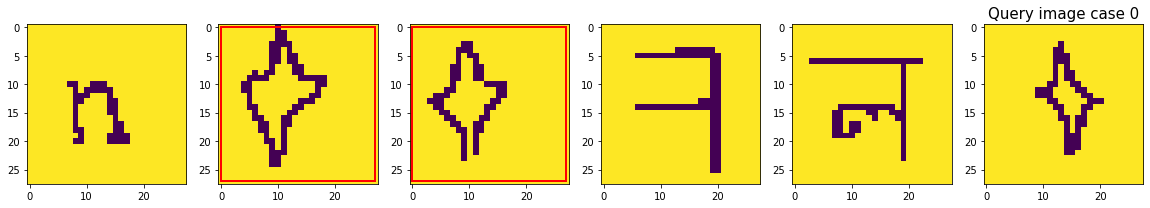

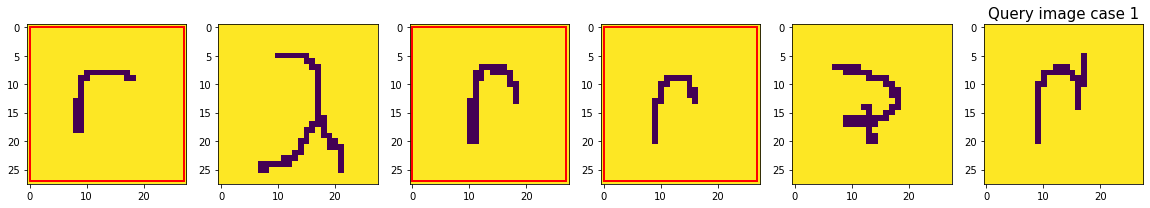

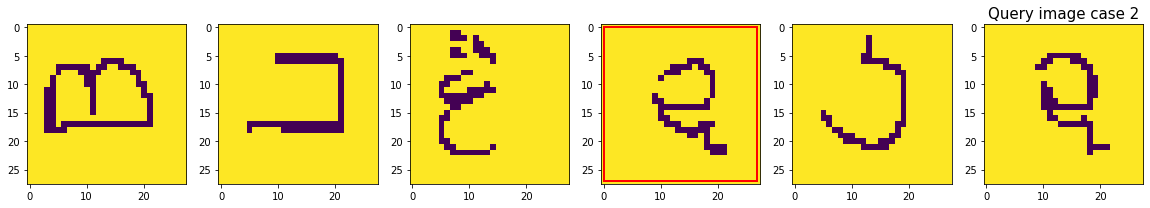

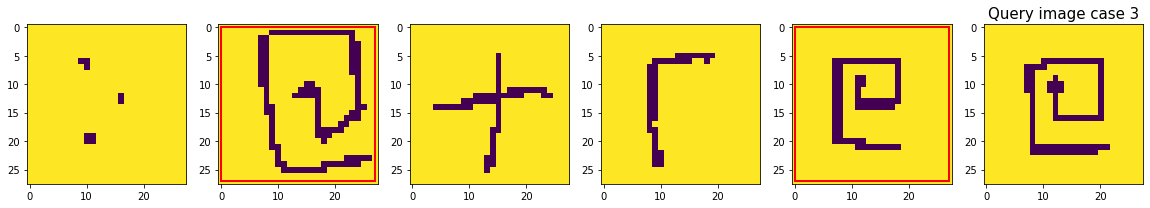

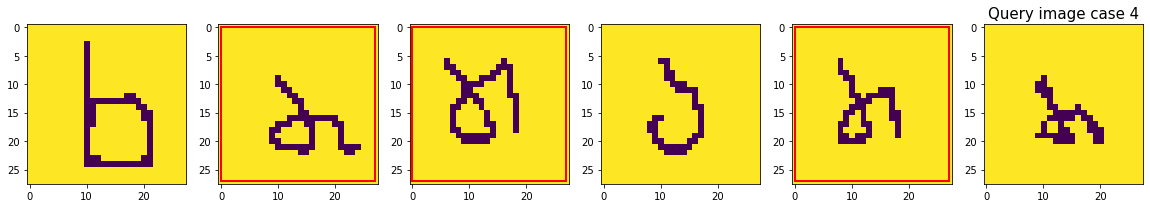

In [5]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [6]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



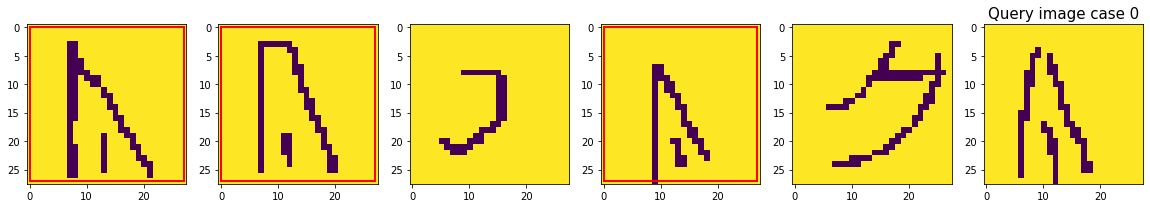

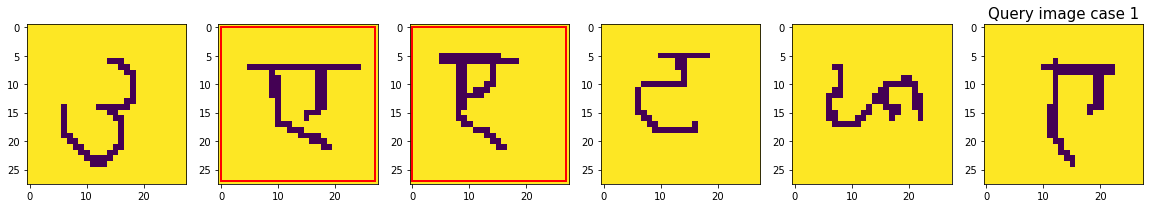

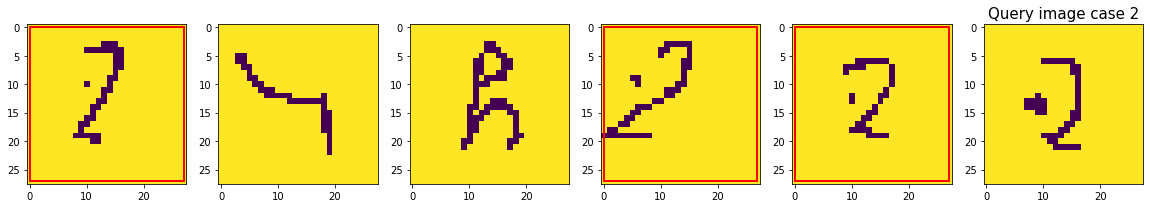

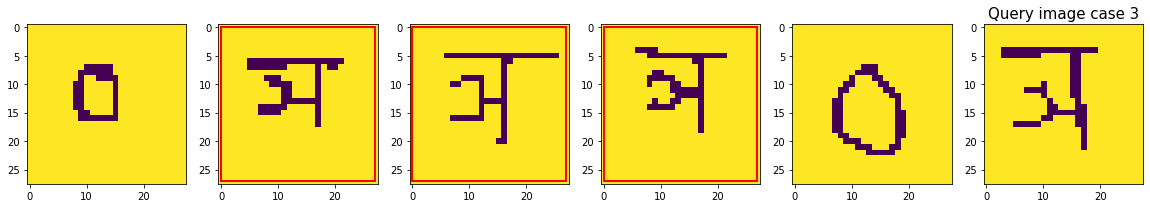

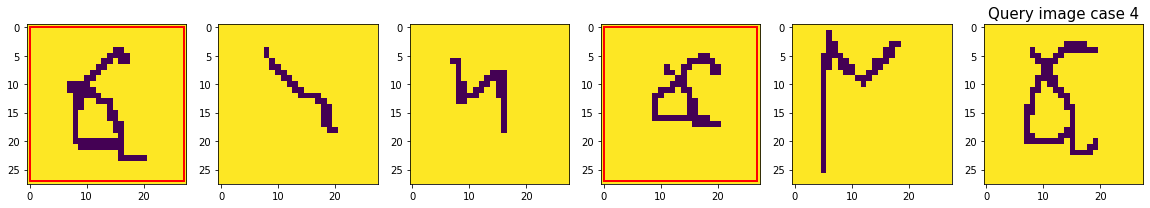

In [7]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [8]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [9]:
# transform = transforms.ToTensor()
train_dataset=MyDataset(train_data,train_label)
test_dataset=MyDataset(test_data,test_label)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)

In [11]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [13]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


# N 5-way one shot trials essentially 
    N <= len(test_set)

In [14]:
## Model Definition ##

### Two CNN Architectures (https://arxiv.org/pdf/1606.04080v2.pdf)

In [15]:
#We will build the two identical CNN architectures
#Create a class for the Siamese-Net

#Implementing a VGG Inspired Architechture
class Siamese_Net(nn.Module):
    def __init__(self):
        super(Siamese_Net, self).__init__()
        #Defining the convolutionnal layers
        self.convnet = nn.Sequential(
        nn.Conv2d(1,64, kernel_size = 3, stride =1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2, stride = 2),
            
        nn.Conv2d(64,128, kernel_size = 3, stride = 1),
        nn.ReLU(inplace = True),
        nn.MaxPool2d(2, stride = 2),
        
        nn.Conv2d(128, 512, kernel_size = 3, stride =1),
        nn.ReLU(inplace = True)
        )
        
        #Defining the Fully Connected Layers
        
        self.FC = nn.Sequential(nn.Linear(512*3*3, 1024),
                               nn.ReLU(inplace = True),
                               
                               nn.Linear(1024, 256),
                               nn.ReLU(inplace = True),
                               nn.Linear(256,2))
        
        
        
        
            
        self.linear = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)
        
    def pass_one(self, x):
        x = self.convnet(x)
        x = x.view(x.size()[0], -1)
        x = self.FC(x)
        return x
    
    def pass_two(self, x1, x2):
        out1 = self.pass_one(x1)
        out2 = self.pass_one(x2)
        output = torch.abs(out1-out2)
        output = F.sigmoid(output)
        return output

In [16]:
## LOSS Definition ##

class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin = 1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        
    def forward(self, out1, out2, label):
        euclidean_distance = F.pairwise_distance(out1 ,out2, keepdim = True)
        contrastive_loss = torch.mean((1-label)*torch.pow(euclidean_distance, 2) +
                                     (label)*torch.pow(F.relu(self.margin - euclidean_distance, min = 0.0), 2))
        
        return contrastive_loss


In [17]:
#peek into the model architecture

SiameseNet = Siamese_Net()

def count_paramaters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_paramaters(SiameseNet)

The model architecture:

 Siamese_Net(
  (convnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU(inplace=True)
  )
  (FC): Sequential(
    (0): Linear(in_features=4608, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=256, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=256, out_features=2, bias=True)
  )
  (linear): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)

The model has 43,404,291 trainable parameters


/tmp/ipykernel_5810/2568722851.py:6: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp = sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
## Build Sample Selector ##

In [ ]:
## Training ##

In [ ]:
def save_model_checkpoint(path, model, optimizer, val_loss ):
    if path == None:
        return print("Kindly define a path")
        

In [ ]:
## Evaluation ##